In [1]:
# Import modules
from google.colab import files
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Dropout
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
import time

In [2]:
#t1_start = time.process_time() 

In [3]:
url="https://raw.githubusercontent.com/zhuppyra/price-forecasting/main/Data%20harga%202016-2021%2010%20komoditas.csv"
df=pd.read_csv(url, index_col='Date', parse_dates=True)
df.index.freq='D'
df.head()

,Shallot,Garlic,Rice,Chili pepper,Cayenne pepper,Broiler meat,Topside beef,Granulated sugar,Cooking oil,Chicken egg
Date,,,,,,,,,,
2016-01-01,35774.0,27588.0,10806.0,39831.0,48486.0,33303.0,110235.0,12838.0,15027.0,25743.0
2016-01-02,35068.0,27750.0,10809.0,40191.0,48146.0,33479.0,110265.0,12909.0,15092.0,25774.0
2016-01-03,35318.0,27728.0,10809.0,39581.0,47396.0,33362.0,110338.0,12909.0,15092.0,25700.0
2016-01-04,35757.0,28084.0,10835.0,39251.0,45896.0,34224.0,110306.0,13017.0,14956.0,25564.0
2016-01-05,36236.0,28037.0,10835.0,39241.0,44021.0,34116.0,110245.0,13020.0,14962.0,25586.0


In [4]:
# checking for missing data
df.isna().any().any()

True

In [5]:
# filling missing data using last observation carried forward (LOCF)
df1 = df.ffill()
# print dataframe shape
print(df1.shape)
# rechecking for missing data
print(df1.isna().any().any())

(2192, 10)
False


In [6]:
# only include start of the week/end of week
df1 = df1.iloc[3:]
df1 = df1.iloc[:-5]
print(df1)

            Shallot   Garlic     Rice  Chili pepper  Cayenne pepper  \
Date                                                                  
2016-01-04  35757.0  28084.0  10835.0       39251.0         45896.0   
2016-01-05  36236.0  28037.0  10835.0       39241.0         44021.0   
2016-01-06  36389.0  27879.0  10841.0       38280.0         43209.0   
2016-01-07  36422.0  27990.0  10839.0       37111.0         42636.0   
2016-01-08  36125.0  27925.0  10827.0       35803.0         41440.0   
...             ...      ...      ...           ...             ...   
2021-12-22  28083.0  27859.0  10312.0       51690.0         91394.0   
2021-12-23  28154.0  27898.0  10313.0       51757.0         92519.0   
2021-12-24  28329.0  28068.0  10329.0       51266.0         94845.0   
2021-12-25  28329.0  28068.0  10329.0       51266.0         94845.0   
2021-12-26  28329.0  28068.0  10329.0       51266.0         94845.0   

            Broiler meat  Topside beef  Granulated sugar  Cooking oil  \
Dat

In [7]:
print(df1.describe())

            Shallot        Garlic          Rice   Chili pepper  \
count   2184.000000   2184.000000   2184.000000    2184.000000   
mean   33308.605311  31554.568223  10573.712454   37079.377289   
std     6671.733968   7130.177343    192.206923    9084.893179   
min    20525.000000  17700.000000   8500.000000   20000.000000   
25%    28321.500000  26734.000000  10479.000000   30645.250000   
50%    32841.000000  29411.500000  10566.000000   34507.000000   
75%    37114.250000  36438.250000  10651.000000   41768.750000   
max    82900.000000  69900.000000  11751.000000  123900.000000   

       Cayenne pepper  Broiler meat   Topside beef  Granulated sugar  \
count     2184.000000   2184.000000    2184.000000       2184.000000   
mean     49696.264194  33304.434066  118777.253663      13403.568681   
std      17684.264109   2277.716259    4412.704624       1264.572248   
min      12000.000000  21700.000000   90000.000000      11500.000000   
25%      37267.250000  31764.250000  116135.0

In [8]:
# isolate desired commodity
comm_name = 'Shallot'
commodity = df1.filter([comm_name])
print(commodity.shape)
commodity.head()

(2184, 1)


,Shallot
Date,
2016-01-04,35757.0
2016-01-05,36236.0
2016-01-06,36389.0
2016-01-07,36422.0
2016-01-08,36125.0


In [9]:
# convert dataframe into numpy array
commodity_ar = np.array(commodity)
print(commodity_ar.shape)
# get the numbers of training data needed
# fitting it to a full week data (hence the +3)
commodity_train_len = int(len(commodity_ar)*.8+3)
commodity_test_len = len(commodity_ar)-commodity_train_len
print(commodity_train_len, commodity_test_len)

(2184, 1)
1750 434


In [10]:
# scaling the data
scaler=MinMaxScaler(feature_range=(0,1))

In [11]:
# making training dataset
commodity_train = commodity_ar[0:commodity_train_len]
print(commodity_train.shape)
commodity_train_scaled = scaler.fit_transform(commodity_train)

(1750, 1)


In [12]:
# creating matrix dataset function
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
# applying new function to create matrix dataset
time_step = 7
X_train, y_train = create_dataset(commodity_train_scaled, time_step)
print(X_train.shape, y_train.shape)

(1743, 7) (1743,)


In [14]:
# reshape data
print(X_train.shape), print(y_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(1743, 7)
(1743,)
(1743, 7, 1)


In [15]:
from keras.layers import Dense, Input, Dropout
from keras.layers import LSTM
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [16]:
np.random.seed(333)
tf.random.set_seed(333)

In [17]:
neuron = 200
n_epoch = 100

In [18]:
#Define input layer which has shape (None, 7) and of type float32.
# None indicates the number of instances
input_layer = Input(shape=(7,1), dtype='float32')
# lstm layer
lstm_layer1 = LSTM(neuron, input_shape=(7,1), return_sequences=True)(input_layer)
lstm_layer2 = LSTM(neuron, input_shape=(7,neuron), return_sequences=False)(lstm_layer1)
#lstm_layer3 = LSTM(neuron, input_shape=(7,neuron), return_sequences=False)(lstm_layer2)
# dropout layer
dropout_layer = Dropout(0.2)(lstm_layer2)
# output layer
output_layer = Dense(1)(dropout_layer)
# compile model
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_absolute_error', optimizer='adam')
ts_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 7, 200)            161600    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 482,601
Trainable params: 482,601
Non-trainable params: 0
_________________________________________________________________


In [19]:
ts_model.fit(x=X_train, y=y_train, batch_size=64, epochs=n_epoch, verbose=1,
             shuffle=True)

Epoch 1/100
28/28 [==============================] - 17s 126ms/step - loss: 0.0496
Epoch 2/100
28/28 [==============================] - 3s 100ms/step - loss: 0.0193
Epoch 3/100
28/28 [==============================] - 2s 66ms/step - loss: 0.0192
Epoch 4/100
28/28 [==============================] - 2s 67ms/step - loss: 0.0181
Epoch 5/100
28/28 [==============================] - 2s 67ms/step - loss: 0.0184
Epoch 6/100
28/28 [==============================] - 2s 64ms/step - loss: 0.0185
Epoch 7/100
28/28 [==============================] - 2s 66ms/step - loss: 0.0180
Epoch 8/100
28/28 [==============================] - 2s 62ms/step - loss: 0.0170
Epoch 9/100
28/28 [==============================] - 2s 63ms/step - loss: 0.0170
Epoch 10/100
28/28 [==============================] - 2s 62ms/step - loss: 0.0172
Epoch 11/100
28/28 [==============================] - 2s 65ms/step - loss: 0.0166
Epoch 12/100
28/28 [==============================] - 2s 64ms/step - loss: 0.0164
Epoch 13/100
28/28 [==

In [20]:
# applying predictin model to training data
train_predict=ts_model.predict(X_train)
train_predict=scaler.inverse_transform(train_predict)
print(train_predict[:5])

55/55 [==============================] - 2s 16ms/step
[[36097.27 ]
 [36939.355]
 [36631.484]
 [36844.42 ]
 [36795.145]]


In [21]:
# making testing dataset
commodity_test = commodity_ar[commodity_train_len:]
print(commodity_test.shape)
# normalizing testing dataset
commodity_test_scaled = scaler.transform(commodity_test)
print(commodity_test_scaled[:5])

(434, 1)
[[0.21561523]
 [0.21359519]
 [0.22771944]
 [0.21673747]
 [0.21507014]]


In [22]:
# applying new function to create matrix testing data
X_test, y_test = create_dataset(commodity_test_scaled, time_step)
print(X_test.shape, y_test.shape)

(427, 7) (427,)


In [23]:
# reshaping testing data to fit LSTM model
print(X_test.shape, y_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(427, 7) (427,)
(427, 7, 1)


In [24]:
# applying prediction model to testing data
test_predict=ts_model.predict(X_test)
# transform to original form
test_predict=scaler.inverse_transform(test_predict)
print(test_predict[:5])

14/14 [==============================] - 0s 16ms/step
[[40033.984]
 [34666.633]
 [34569.355]
 [37842.14 ]
 [37874.05 ]]


In [25]:
# mape calculation
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


commodity_test_data = commodity_ar[len(train_predict)+
                                   (time_step*2):len(commodity_ar)]
commodity_train_data = commodity_ar[time_step:commodity_train_len]
print(commodity_test_data.shape, commodity_train_data.shape)
print('Testing Data Prediction with LSTM MAPE score:',
      mape(commodity_test_data, test_predict))
print('Training Data Prediction with LSTM MAPE score:',
      mape(commodity_train_data, train_predict))

(427, 1) (1743, 1)
Testing Data Prediction with LSTM MAPE score: 1.2996012657660831
Training Data Prediction with LSTM MAPE score: 1.6142221491656645


In [26]:
# MAE and MdAE calculation
print('LSTM MdAE score:', median_absolute_error(commodity_test_data,
                                                test_predict))
print('LSTM MAE score:', mean_absolute_error(commodity_test_data,
                                             test_predict))

LSTM MdAE score: 199.70703125
LSTM MAE score: 428.8380644394028


In [27]:
# MSE and RMSE calculation
print('LSTM MSE score:', mean_squared_error(commodity_test_data,
                                            test_predict))
print('LSTM RMSE score:', mean_squared_error(commodity_test_data,
                                             test_predict, squared=False))

LSTM MSE score: 908419.9109341535
LSTM RMSE score: 953.1106498902179


In [28]:
print('LSTM MAPE score:',
      mape(commodity_test_data, test_predict))
print('LSTM MAE score:', mean_absolute_error(commodity_test_data,
                                             test_predict))

LSTM MAPE score: 1.2996012657660831
LSTM MAE score: 428.8380644394028


In [29]:
test_predict=pd.DataFrame(test_predict)
test_predict.index=commodity.index[len(train_predict)+
                                   (time_step*2):len(commodity_ar)]

In [30]:
commodity_test_data=pd.DataFrame(commodity_test_data)
commodity_test_data.index=commodity.index[len(train_predict)+
                                   (time_step*2):len(commodity_ar)]

(array([18561, 18628, 18718, 18809, 18901, 18987]),
 <a list of 6 Text major ticklabel objects>)

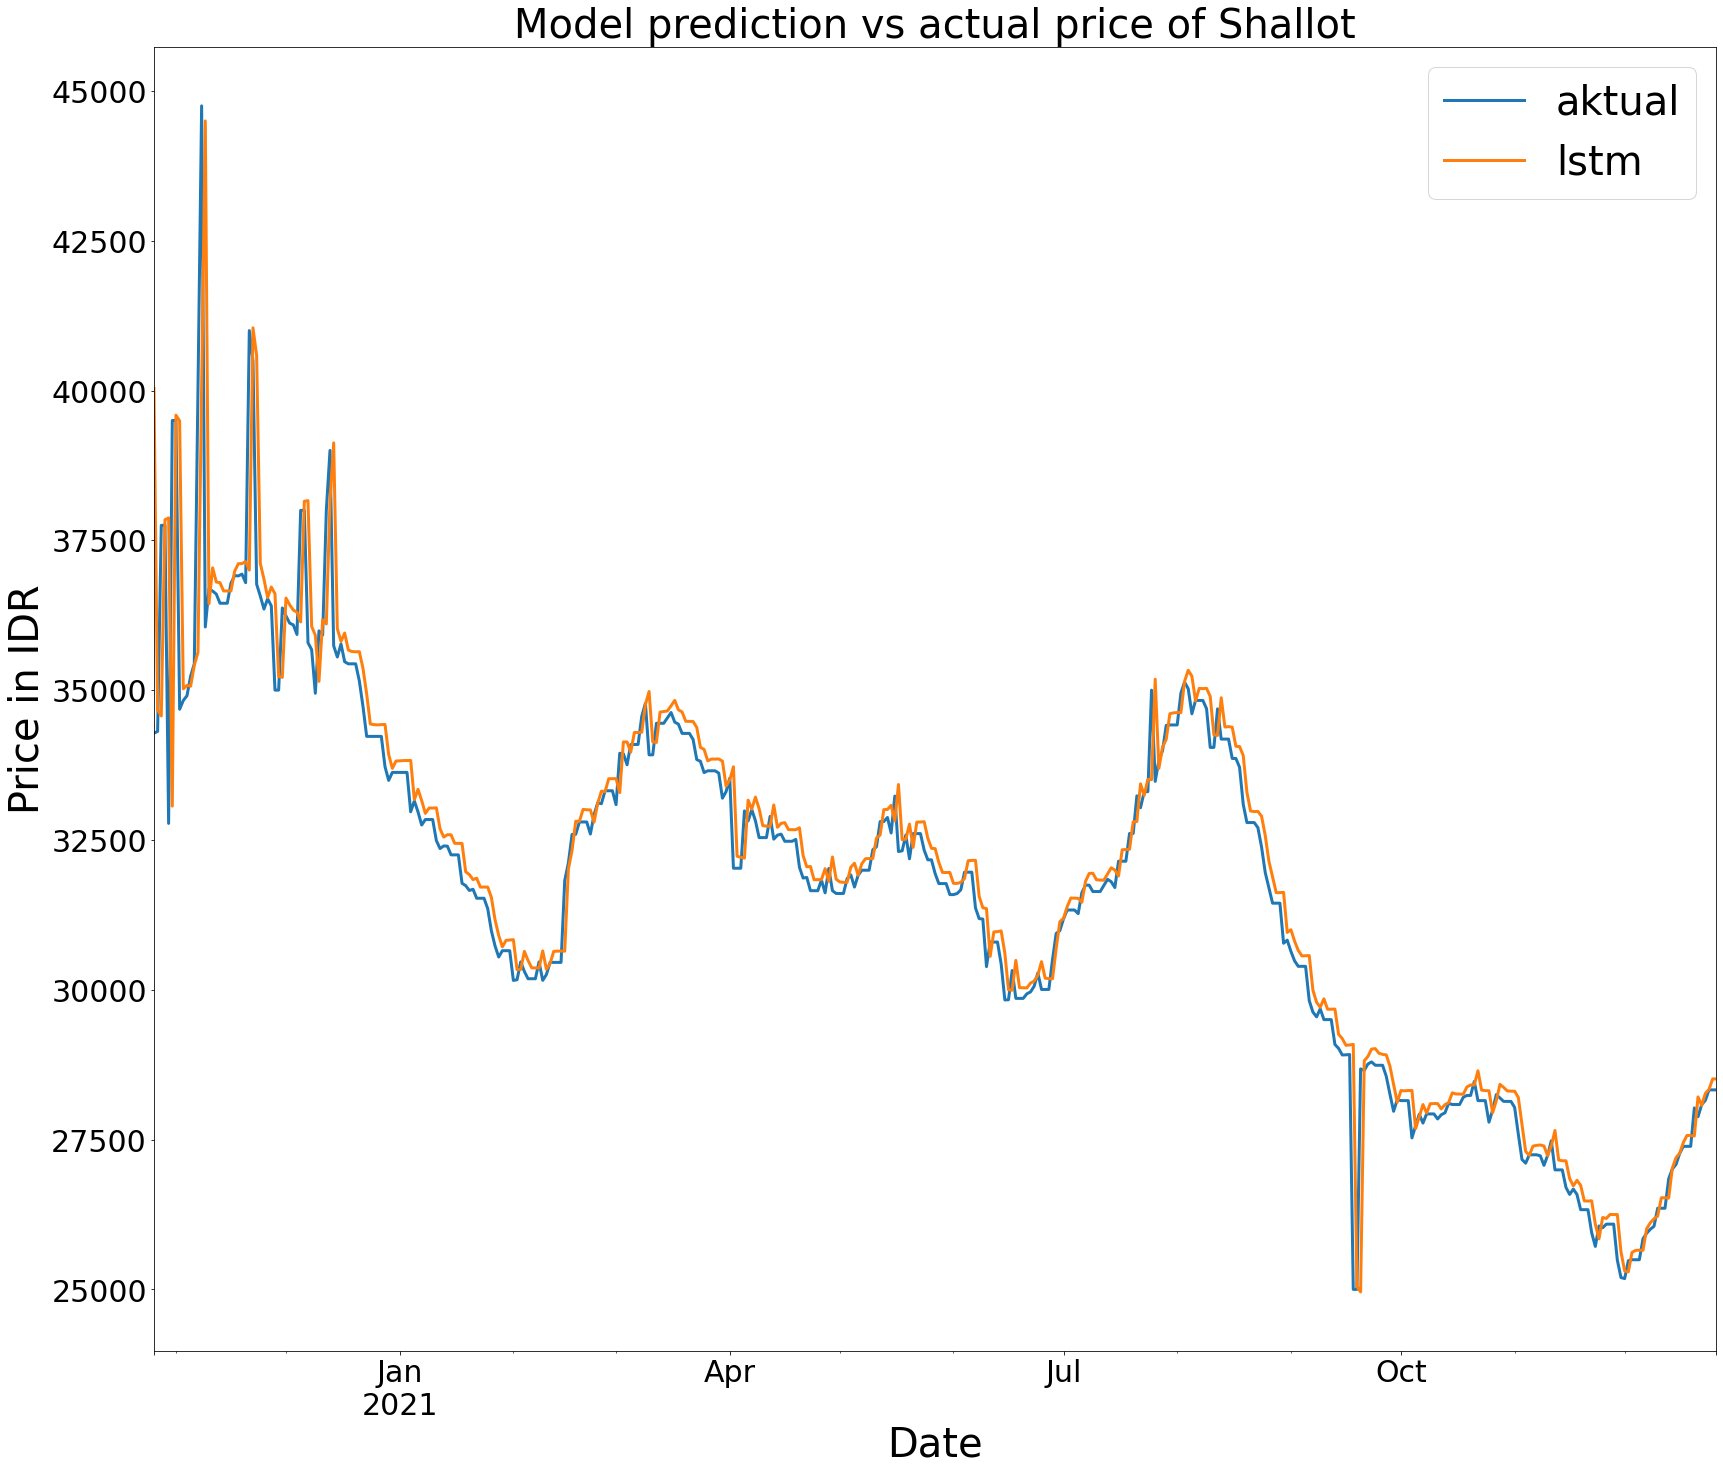

In [31]:
fig,ax=plt.subplots(figsize=(28,24))
commodity_test_data.plot(ax=ax,linewidth=3)
test_predict.plot(ax=ax,linewidth=3)
ax.set_title(f'Model prediction vs actual price of {comm_name}',
             size=40)
ax.legend([
           "aktual",
           "lstm",
           ],fontsize=40)
ax.set_ylabel('Price in IDR', size=40)
ax.set_xlabel('Date', size=40)
plt.yticks(fontsize=30,)
plt.xticks(fontsize=30,)

In [32]:
pd.DataFrame(test_predict, columns=[0]).to_csv('revised_lstm_rice.csv')
files.download("revised_lstm_rice.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>